In [77]:
import numpy as np
import matplotlib.pyplot as plt

In [78]:
from keras.datasets import mnist

In [79]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [80]:
X_train = X_train/255
X_test = X_test/255

In [81]:
X_7 = X_train[y_train == 7]

In [82]:
print(len(X7))

6265


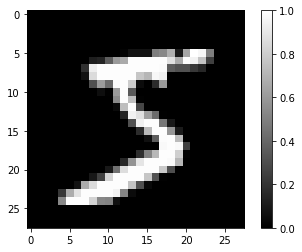

In [83]:
plt.imshow(X_train[0], cmap='gray')
plt.colorbar()

In [84]:
X_train = X_train[:,:,:,np.newaxis] # X_train.reshape(-1,28,28,1)
X_test = X_test[:,:,:,np.newaxis]

In [85]:
X_train.shape, X_train.dtype, X_train.max(), X_train.min()

((60000, 28, 28, 1), dtype('float64'), 1.0, 0.0)

In [86]:
X_test.shape

(10000, 28, 28, 1)

In [87]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, \
    Flatten, Reshape, LeakyReLU, BatchNormalization, Activation
from keras.optimizers import RMSprop

In [88]:
input = Input((28,28,1))
x = LeakyReLU(alpha=0.2)(input)

x = Conv2D(32, (5,5), strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(64, (5,5), strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(128, (5,5), strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(256, (5,5), strides=1, padding='same')(x)

x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

discriminator = Model(input, x)
discriminator.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 128)         2049

In [89]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer=RMSprop(lr=2e-4, decay=6e-8), metrics=['acc'])
    # decay 값이 클수록 새롭게(처음으로) 변경되는 가중치를 많이 변화시킨다 (디폴트:0)

In [90]:
input2 = Input((100,)) # 생성벡터는 100차원

x2 = Dense(7*7*128)(input2) # 랜덤 이미지가 입력됨

x2 = Reshape((7,7,128))(x2)

x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(128, (5,5), strides=2, padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(64, (5,5), strides=2, padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(32, (5,5), strides=1, padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(1, (5,5), strides=1, padding='same')(x2)
x2 = Activation('sigmoid')(x2)

generator = Model(input2, x2)
generator.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
activation_11 (Activation)   (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization_10 (Batc (None, 14, 14, 128)       512

In [91]:
discriminator.trainable = False # 모델들을 연결하여 새로운 모델을 만들 때만 적용된다

adversarial = Model(input2, discriminator(generator(input2)))
adversarial.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_10 (Model)             (None, 28, 28, 1)         1301505   
_________________________________________________________________
model_9 (Model)              (None, 1)                 1080577   
Total params: 2,382,082
Trainable params: 1,300,801
Non-trainable params: 1,081,281
_________________________________________________________________


In [92]:
adversarial.compile(loss='binary_crossentropy',
            optimizer=RMSprop(lr=2e-4*0.5, decay=6e-8*0.5), metrics=['acc'])

In [93]:
from keras.preprocessing import image

batch_size = 64
logs = [] # d_loss,d_acc,a_loss,a_acc

for step in range(20): # 400
    indices = np.random.randint(0, len(X_7), size=batch_size)
    real_images = X_7[indices]
    
    gen_vectors = np.random.uniform(-1, 1, size=[batch_size,100])
    fake_images = generator.predict(gen_vectors)
    
    X = np.r_[real_images, fake_images] # [batch_size*2,32,32,1]
    y = np.r_[np.ones([batch_size,1]), np.zeros([batch_size,1])] # [batch_size*2,1]
        # fake: 0, real: 1
        
    ###########
    d_loss, d_acc = discriminator.train_on_batch(X, y)
    
    gen_vectors_2 = np.random.uniform(-1, 1, size=[batch_size,100])
    ###########
    a_loss, a_acc = adversarial.train_on_batch(gen_vectors_2, np.ones([batch_size,1]))
            # 타겟값을 모두 1로 놓는다
    
    logs.append([d_loss,d_acc,a_loss,a_acc])
    print('Step: %05d, ' % (step+1), logs[-1])
    
    if (step+1)%10 == 0:
        adversarial.save_weights('gan_mnist.h5')
    
        img = image.array_to_img(fake_images[0]*255., scale=False)
        #img.save('gan_images/fake_'+str(step)+'.png')

ValueError: all the input arrays must have same number of dimensions

In [ ]:
generator.save('gan_mnist_generator_20.h5')

In [ ]:
from keras.preprocessing import image

batch_size = 64

for step in range(400,1000): # 40000
    idx = np.random.randint(0, len(X_7), size=batch_size)
    real_images = X_7[idx]
    
    gen_vectors = np.random.uniform(-1, 1, size=[batch_size,100])
    fake_images = generator.predict(gen_vectors)
    
    X = np.r_[real_images, fake_images] # [batch_size*2,32,32,1]
    y = np.r_[np.ones([batch_size,1]), np.zeros([batch_size,1])] # [batch_size*2,1]
        # fake: 0, real: 1
        
    ###########
    d_loss, d_acc = discriminator.train_on_batch(X, y)
    
    gen_vectors_2 = np.random.uniform(-1, 1, size=[batch_size,100])
    ###########
    a_loss, a_acc = adversarial.train_on_batch(gen_vectors_2, np.ones([batch_size,1]))
    
    logs.append([d_loss,d_acc,a_loss,a_acc])
    print('Step: %05d, [%.3f, %.3f, %.3f, %.3f]' % (step+1,d_loss,d_acc,a_loss,a_acc))
    
    if (step+1)%10 == 0:
        adversarial.save_weights('gan_mnist.h5')
    
        img = image.array_to_img(fake_images[0]*255., scale=False)
        #img.save('gan_images/fake_'+str(step)+'.png')

In [ ]:
generator.save('gan_mnist_generator_1000.h5')

In [ ]:
np.save('gan_mnist_log.npy', logs)

In [ ]:
plt.plot([i[0] for i in logs][::10], 'b-', label='d_loss')
plt.plot([i[2] for i in logs][::10], 'r-', label='a_loss')
plt.legend()

In [ ]:
plt.plot([i[1] for i in logs][::10], 'b-', label='d_acc')
plt.plot([i[3] for i in logs][::10], 'r-', label='a_acc')
plt.legend()

In [94]:
from keras.models import load_model

#generator = load_model('gan_mnist_generator_1000.h5')

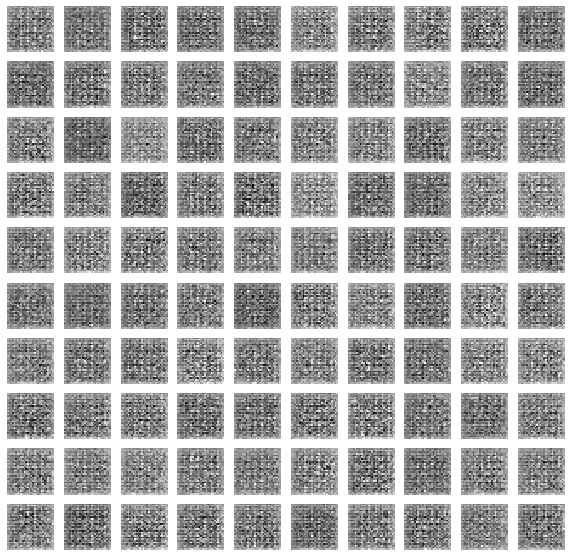

In [95]:
vectors = np.random.uniform(-1, 1, size=[100,100])
images = generator.predict(vectors)

plt.figure(figsize=[10,10])
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(images[i].reshape(28,28), cmap='gray')
    plt.axis('off')

In [96]:
from keras.datasets.fashion_mnist import load_data

In [97]:
fmnist = load_data()

In [98]:
fmnist[1][0].shape

(10000, 28, 28)